# Phase 4: Custom Loss Functions for Meta-Labeling

## Overview
This notebook implements custom loss functions adapted from swim_code for financial meta-labeling:
- **ConsistentPeakBFCE**: Adapted for regression heatmaps (ensures strong signals have high confidence)
- **Focal Loss**: Focuses on hard-to-classify examples
- **Combined Loss**: Weighted combination for dual-branch training

## Key Adaptations
1. **From Binary [0,1] → Signed Regression [-1,+1]**:
   - Original: Binary stroke detection (0=no stroke, 1=stroke)
   - Adapted: Signed heatmap ([-1,0]=losing trades, [0,+1]=winning trades)

2. **Peak Consistency**:
   - Original: Penalize low predictions in peak regions (stroke events)
   - Adapted: Penalize weak predictions for strong signals (high |heatmap| values)

3. **Threshold-Based Penalties**:
   - Encourage model to be confident when heatmap magnitude is high
   - Allow uncertainty when heatmap magnitude is low

---

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.optimizers import Adam

# Sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


## 2. Custom Loss Functions

### 2.1 Focal Loss (Adapted for Regression)

Original focal loss for classification, adapted for regression tasks:
- Focuses on hard examples (large errors)
- Down-weights easy examples (small errors)

In [ ]:
class FocalMSELoss(tf.keras.losses.Loss):
    """
    Focal loss adapted for regression tasks.
    Focuses learning on hard-to-predict examples.
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Scaling factor
    """
    def __init__(self, gamma=2.0, alpha=1.0, name="focal_mse_loss"):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha
    
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Ensure shape compatibility
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        
        # Calculate MSE
        mse = tf.square(y_true - y_pred)
        
        # Normalize error to [0, 1] for focal weighting
        # Max possible error is 4 (from -1 to +1)
        normalized_error = mse / 4.0
        
        # Apply focal weighting: hard examples get higher weight
        focal_weight = tf.pow(normalized_error, self.gamma)
        
        # Weighted loss
        focal_loss = self.alpha * focal_weight * mse
        
        return tf.reduce_mean(focal_loss)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'gamma': self.gamma,
            'alpha': self.alpha
        })
        return config

### 2.2 ConsistentPeakLoss (Adapted from ConsistentPeakBFCE)

Key adaptation from binary stroke detection to signed regression:
- **Original**: Penalize low predictions (< 0.85) in peak regions (y_true > 0.6)
- **Adapted**: Penalize weak predictions when |y_true| is high (strong signal)
  - For positive signals: Penalize if prediction < target_height
  - For negative signals: Penalize if prediction > -target_height
  - Allow flexibility when |y_true| is low (weak/uncertain signals)

In [ ]:
class ConsistentPeakLoss(tf.keras.losses.Loss):
    """
    Adapted from swim_code ConsistentPeakBFCE for signed regression.
    
    Ensures model is confident when heatmap signals are strong:
    - Strong positive signal (y_true > threshold): prediction should be high positive
    - Strong negative signal (y_true < -threshold): prediction should be high negative
    - Weak signal (|y_true| < threshold): allow flexibility
    
    Args:
        target_height: Target confidence level (e.g., 0.7 means predict ±0.7 for strong signals)
        peak_threshold: Threshold for "strong signal" (e.g., 0.5 means |y_true| > 0.5)
        peak_weight: Weight for peak consistency penalty
        base_loss: Base regression loss (MSE or Huber)
    """
    def __init__(self, 
                 target_height=0.7,
                 peak_threshold=0.5,
                 peak_weight=0.3,
                 base_loss='mse',
                 name="consistent_peak_loss"):
        super().__init__(name=name)
        self.target_height = target_height
        self.peak_threshold = peak_threshold
        self.peak_weight = peak_weight
        self.base_loss = base_loss
    
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Ensure shape compatibility
        original_shape = tf.shape(y_true)
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        
        # Base regression loss (simple MSE to avoid axis issues)
        if self.base_loss == 'mse':
            base_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        elif self.base_loss == 'huber':
            delta = 1.0
            abs_error = tf.abs(y_true - y_pred)
            quadratic = tf.minimum(abs_error, delta)
            linear = abs_error - quadratic
            base_loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
        else:
            base_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # === Peak Consistency Penalty ===
        # Identify strong signals (high magnitude)
        strong_signal_mask = tf.cast(tf.abs(y_true) > self.peak_threshold, tf.float32)
        
        # For positive strong signals: target is +target_height
        # For negative strong signals: target is -target_height
        target_values = tf.sign(y_true) * self.target_height * strong_signal_mask
        
        # Identify weak predictions in strong signal regions
        # Positive signals: prediction should be > +target_height
        # Negative signals: prediction should be < -target_height
        signed_pred_magnitude = y_pred * tf.sign(y_true)  # Align with true signal direction
        weak_prediction_mask = tf.cast(signed_pred_magnitude < self.target_height, tf.float32)
        
        # Combined penalty mask: strong signal AND weak prediction
        penalty_mask = strong_signal_mask * weak_prediction_mask
        
        # Calculate penalty (MSE between prediction and target, only in penalty regions)
        peak_mse = tf.square(y_pred - target_values) * penalty_mask
        
        # Average penalty (avoid division by zero)
        num_penalty_points = tf.reduce_sum(penalty_mask)
        peak_loss = tf.cond(
            tf.greater(num_penalty_points, 0),
            lambda: tf.reduce_sum(peak_mse) / num_penalty_points,
            lambda: 0.0
        )
        
        # Combined loss
        total_loss = base_loss + self.peak_weight * peak_loss
        
        return total_loss
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'target_height': self.target_height,
            'peak_threshold': self.peak_threshold,
            'peak_weight': self.peak_weight
        })
        return config

### 2.3 Combined Dual-Branch Loss

Wrapper for dual-branch model with different losses for each output

In [4]:
def create_dual_branch_losses(classification_weight=0.4, regression_weight=0.6,
                              use_focal=False, use_consistent_peak=True,
                              peak_threshold=0.5, target_height=0.7, peak_weight=0.3):
    """
    Create loss configuration for dual-branch model.
    
    Args:
        classification_weight: Weight for classification branch
        regression_weight: Weight for regression branch
        use_focal: Use focal loss for regression
        use_consistent_peak: Use consistent peak loss for regression
        peak_threshold: Threshold for strong signals
        target_height: Target confidence for strong signals
        peak_weight: Weight for peak consistency penalty
    
    Returns:
        loss_dict: Dictionary of losses for each output
        loss_weights: Dictionary of weights for each output
    """
    # Classification loss (always binary crossentropy)
    classification_loss = 'binary_crossentropy'
    
    # Regression loss selection
    if use_consistent_peak:
        regression_loss = ConsistentPeakLoss(
            target_height=target_height,
            peak_threshold=peak_threshold,
            peak_weight=peak_weight,
            base_loss='mse'
        )
    elif use_focal:
        regression_loss = FocalMSELoss(gamma=2.0, alpha=1.0)
    else:
        regression_loss = 'mse'
    
    loss_dict = {
        'classification_output': classification_loss,
        'regression_output': regression_loss
    }
    
    loss_weights = {
        'classification_output': classification_weight,
        'regression_output': regression_weight
    }
    
    return loss_dict, loss_weights

## 3. Test Loss Functions with Synthetic Data

Verify loss behavior before training

In [5]:
# Create synthetic data
np.random.seed(42)
n_samples = 1000

# True values: mix of strong and weak signals
y_true_strong_pos = np.random.uniform(0.6, 1.0, size=(n_samples // 4, 1))  # Strong positive
y_true_weak_pos = np.random.uniform(0.0, 0.4, size=(n_samples // 4, 1))   # Weak positive
y_true_weak_neg = np.random.uniform(-0.4, 0.0, size=(n_samples // 4, 1))  # Weak negative
y_true_strong_neg = np.random.uniform(-1.0, -0.6, size=(n_samples // 4, 1)) # Strong negative
y_true = np.vstack([y_true_strong_pos, y_true_weak_pos, y_true_weak_neg, y_true_strong_neg])

# Predictions: some good, some bad
y_pred_good = y_true + np.random.normal(0, 0.1, size=y_true.shape)  # Good predictions
y_pred_weak = y_true * 0.5  # Weak predictions (underconfident)
y_pred_random = np.random.uniform(-1, 1, size=y_true.shape)  # Random predictions

print("Synthetic data created:")
print(f"  y_true range: [{y_true.min():.2f}, {y_true.max():.2f}]")
print(f"  Strong signals (|y| > 0.5): {np.sum(np.abs(y_true) > 0.5)} / {len(y_true)}")

Synthetic data created:
  y_true range: [-1.00, 0.99]
  Strong signals (|y| > 0.5): 500 / 1000


### 3.1 Compare Loss Values


Loss Comparison:
Prediction      MSE    Focal MSE  Consistent Peak
      Good 0.009868 8.226760e-07         0.013050
      Weak 0.089147 1.736705e-04         0.116928
    Random 0.690476 1.547614e-01         0.970642


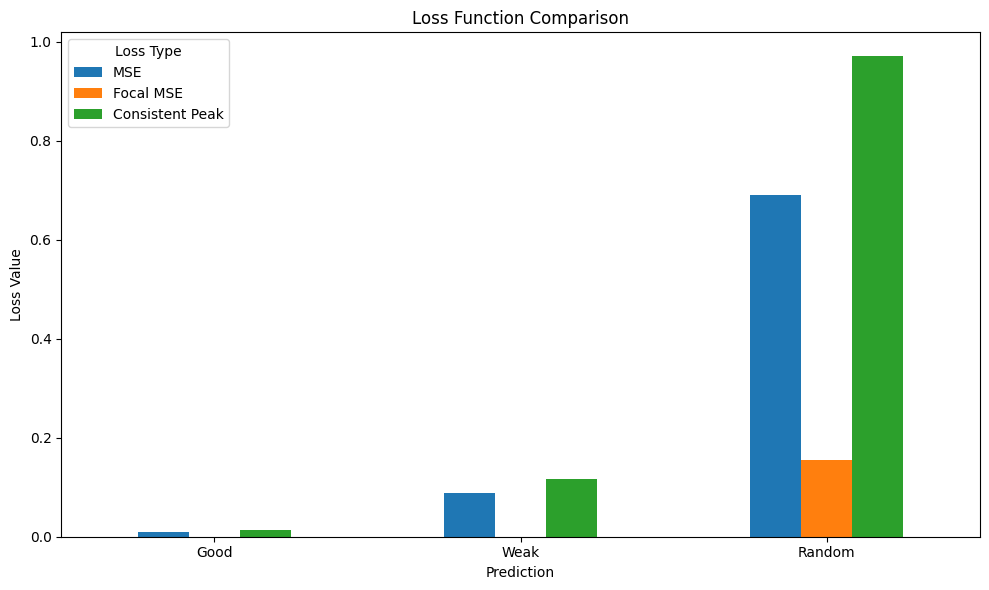


Interpretation:
  - Good predictions: All losses should be low
  - Weak predictions: ConsistentPeak should penalize more (underconfidence on strong signals)
  - Random predictions: All losses should be high


In [6]:
# Initialize losses
mse_loss = tf.keras.losses.MeanSquaredError()
focal_loss = FocalMSELoss(gamma=2.0)
peak_loss = ConsistentPeakLoss(target_height=0.7, peak_threshold=0.5, peak_weight=0.3)

# Compute losses for different prediction qualities
results = []

for pred_name, y_pred in [("Good", y_pred_good), ("Weak", y_pred_weak), ("Random", y_pred_random)]:
    mse_val = mse_loss(y_true, y_pred).numpy()
    focal_val = focal_loss(y_true, y_pred).numpy()
    peak_val = peak_loss(y_true, y_pred).numpy()
    
    results.append({
        'Prediction': pred_name,
        'MSE': mse_val,
        'Focal MSE': focal_val,
        'Consistent Peak': peak_val
    })

results_df = pd.DataFrame(results)
print("\nLoss Comparison:")
print(results_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
results_df.set_index('Prediction').plot(kind='bar', ax=ax)
ax.set_title('Loss Function Comparison')
ax.set_ylabel('Loss Value')
ax.legend(title='Loss Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Good predictions: All losses should be low")
print("  - Weak predictions: ConsistentPeak should penalize more (underconfidence on strong signals)")
print("  - Random predictions: All losses should be high")

### 3.2 Visualize Loss Behavior

InvalidArgumentError: {{function_node __wrapped__Mean_device_/job:localhost/replica:0/task:0/device:CPU:0}} Invalid reduction dimension (-1 for input with 0 dimension(s) [Op:Mean] name: 

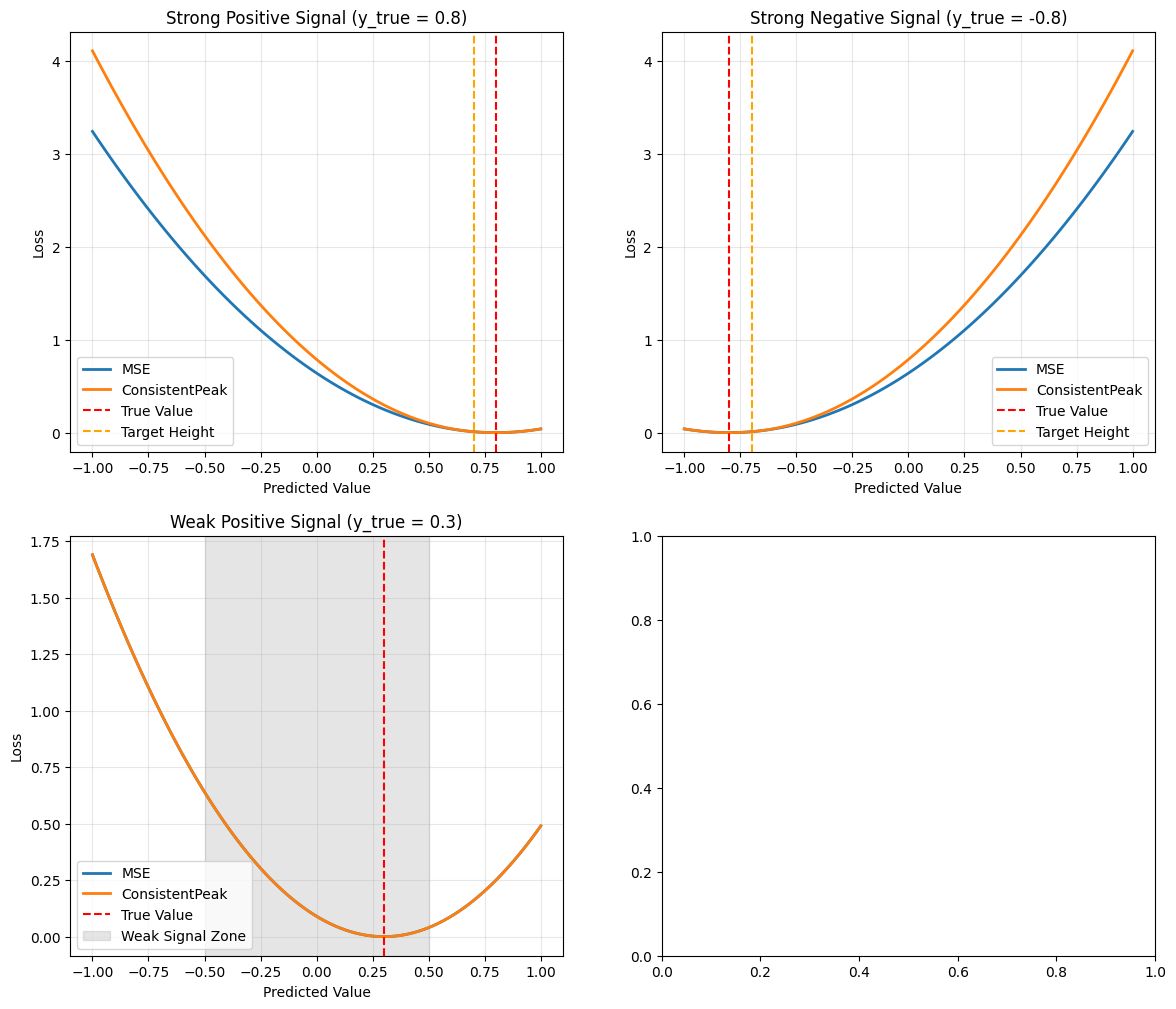

In [7]:
# Create a grid of true values and predictions
y_true_grid = np.linspace(-1, 1, 100).reshape(-1, 1)
y_pred_grid = np.linspace(-1, 1, 100).reshape(-1, 1)

# Compute loss for different scenarios
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Scenario 1: Strong positive signal (y_true = 0.8)
y_true_fixed = np.full_like(y_pred_grid, 0.8)
mse_vals = [mse_loss(y_true_fixed, y_pred_grid[i:i+1]).numpy() for i in range(len(y_pred_grid))]
peak_vals = [peak_loss(y_true_fixed, y_pred_grid[i:i+1]).numpy() for i in range(len(y_pred_grid))]

axes[0, 0].plot(y_pred_grid, mse_vals, label='MSE', linewidth=2)
axes[0, 0].plot(y_pred_grid, peak_vals, label='ConsistentPeak', linewidth=2)
axes[0, 0].axvline(0.8, color='red', linestyle='--', label='True Value')
axes[0, 0].axvline(0.7, color='orange', linestyle='--', label='Target Height')
axes[0, 0].set_title('Strong Positive Signal (y_true = 0.8)')
axes[0, 0].set_xlabel('Predicted Value')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Scenario 2: Strong negative signal (y_true = -0.8)
y_true_fixed = np.full_like(y_pred_grid, -0.8)
mse_vals = [mse_loss(y_true_fixed, y_pred_grid[i:i+1]).numpy() for i in range(len(y_pred_grid))]
peak_vals = [peak_loss(y_true_fixed, y_pred_grid[i:i+1]).numpy() for i in range(len(y_pred_grid))]

axes[0, 1].plot(y_pred_grid, mse_vals, label='MSE', linewidth=2)
axes[0, 1].plot(y_pred_grid, peak_vals, label='ConsistentPeak', linewidth=2)
axes[0, 1].axvline(-0.8, color='red', linestyle='--', label='True Value')
axes[0, 1].axvline(-0.7, color='orange', linestyle='--', label='Target Height')
axes[0, 1].set_title('Strong Negative Signal (y_true = -0.8)')
axes[0, 1].set_xlabel('Predicted Value')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scenario 3: Weak positive signal (y_true = 0.3)
y_true_fixed = np.full_like(y_pred_grid, 0.3)
mse_vals = [mse_loss(y_true_fixed, y_pred_grid[i:i+1]).numpy() for i in range(len(y_pred_grid))]
peak_vals = [peak_loss(y_true_fixed, y_pred_grid[i:i+1]).numpy() for i in range(len(y_pred_grid))]

axes[1, 0].plot(y_pred_grid, mse_vals, label='MSE', linewidth=2)
axes[1, 0].plot(y_pred_grid, peak_vals, label='ConsistentPeak', linewidth=2)
axes[1, 0].axvline(0.3, color='red', linestyle='--', label='True Value')
axes[1, 0].axvspan(-0.5, 0.5, alpha=0.2, color='gray', label='Weak Signal Zone')
axes[1, 0].set_title('Weak Positive Signal (y_true = 0.3)')
axes[1, 0].set_xlabel('Predicted Value')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scenario 4: Perfect prediction landscape
loss_surface = np.zeros((len(y_true_grid), len(y_pred_grid)))
for i, yt in enumerate(y_true_grid):
    for j, yp in enumerate(y_pred_grid):
        loss_surface[i, j] = peak_loss(yt, yp).numpy()

im = axes[1, 1].imshow(loss_surface, extent=[-1, 1, -1, 1], origin='lower', aspect='auto', cmap='viridis')
axes[1, 1].plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].axhline(0.5, color='orange', linestyle='--', alpha=0.7, label='Peak Threshold')
axes[1, 1].axhline(-0.5, color='orange', linestyle='--', alpha=0.7)
axes[1, 1].set_title('ConsistentPeak Loss Surface')
axes[1, 1].set_xlabel('Predicted Value')
axes[1, 1].set_ylabel('True Value')
axes[1, 1].legend()
plt.colorbar(im, ax=axes[1, 1], label='Loss')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  1. Strong signals: ConsistentPeak penalizes underconfident predictions MORE than MSE")
print("  2. Weak signals: Both losses behave similarly (no extra penalty)")
print("  3. Loss surface: Dark diagonal = perfect prediction, lighter = higher penalty")

## 4. Load Phase 3 Model and Retrain with Custom Losses

In [8]:
# Paths
DATA_DIR = Path('../DATA')
MODEL_DIR = Path('../MODELS')
PHASE3_MODEL = MODEL_DIR / 'best_model.keras'
PHASE4_MODEL_DIR = Path('../MODELS_PHASE4')
PHASE4_MODEL_DIR.mkdir(exist_ok=True)

# Load data
print("Loading data...")
X_train = np.load(DATA_DIR / 'X_train_scaled.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val_scaled.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test_scaled.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')

# Prepare dual targets (same as Phase 3)
CONFIDENCE_THRESHOLD = 0.3
y_train_class = (np.abs(y_train) > CONFIDENCE_THRESHOLD).astype(np.float32)
y_val_class = (np.abs(y_val) > CONFIDENCE_THRESHOLD).astype(np.float32)
y_test_class = (np.abs(y_test) > CONFIDENCE_THRESHOLD).astype(np.float32)
y_train_reg = y_train.astype(np.float32)
y_val_reg = y_val.astype(np.float32)
y_test_reg = y_test.astype(np.float32)

print(f"\nData loaded:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train_class: {y_train_class.shape} (good bets: {y_train_class.mean():.2%})")
print(f"  y_train_reg: {y_train_reg.shape} (mean: {y_train_reg.mean():.4f})")

Loading data...

Data loaded:
  X_train: (9496, 60, 28)
  y_train_class: (9496,) (good bets: 15.60%)
  y_train_reg: (9496,) (mean: -0.0226)


In [9]:
# Check if Phase 3 model exists
if PHASE3_MODEL.exists():
    print(f"Loading Phase 3 model from {PHASE3_MODEL}")
    # Load architecture (we'll recompile with new losses)
    model = keras.models.load_model(PHASE3_MODEL, compile=False)
    print("Phase 3 model loaded (will recompile with custom losses)")
else:
    print(f"Phase 3 model not found at {PHASE3_MODEL}")
    print("Please run Phase 3 notebook first to train the base model.")
    raise FileNotFoundError("Phase 3 model required")

Loading Phase 3 model from ..\MODELS\best_model.keras
Phase 3 model loaded (will recompile with custom losses)


## 5. Recompile with Custom Losses

In [10]:
# Loss configuration
LOSS_CONFIG = {
    'classification_weight': 0.4,
    'regression_weight': 0.6,
    'use_focal': False,
    'use_consistent_peak': True,
    'peak_threshold': 0.5,  # Strong signal if |heatmap| > 0.5
    'target_height': 0.7,   # Target confidence for strong signals
    'peak_weight': 0.3      # Weight for peak consistency penalty
}

# Create losses
loss_dict, loss_weights = create_dual_branch_losses(**LOSS_CONFIG)

print("Loss configuration:")
print(f"  Classification: {loss_dict['classification_output']} (weight={loss_weights['classification_output']})")
print(f"  Regression: {loss_dict['regression_output'].__class__.__name__} (weight={loss_weights['regression_output']})")
if LOSS_CONFIG['use_consistent_peak']:
    print(f"    - Peak threshold: {LOSS_CONFIG['peak_threshold']}")
    print(f"    - Target height: {LOSS_CONFIG['target_height']}")
    print(f"    - Peak weight: {LOSS_CONFIG['peak_weight']}")

# Recompile model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower LR for fine-tuning
    loss=loss_dict,
    loss_weights=loss_weights,
    metrics={
        'classification_output': ['accuracy', tf.keras.metrics.AUC(name='auc')],
        'regression_output': ['mae', 'mse']
    }
)

print("\nModel recompiled with custom losses!")

Loss configuration:
  Classification: binary_crossentropy (weight=0.4)
  Regression: ConsistentPeakLoss (weight=0.6)
    - Peak threshold: 0.5
    - Target height: 0.7
    - Peak weight: 0.3

Model recompiled with custom losses!


## 6. Setup Callbacks

In [11]:
checkpoint_path = PHASE4_MODEL_DIR / 'best_model_custom_loss.keras'
log_dir = PHASE4_MODEL_DIR / 'logs'
log_dir.mkdir(exist_ok=True)

callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    callbacks.CSVLogger(
        PHASE4_MODEL_DIR / 'training_history.csv'
    )
]

print("Callbacks configured.")

Callbacks configured.


## 7. Fine-Tune with Custom Losses

In [12]:
print("Starting fine-tuning with custom losses...\n")

history = model.fit(
    X_train,
    {
        'classification_output': y_train_class,
        'regression_output': y_train_reg
    },
    validation_data=(
        X_val,
        {
            'classification_output': y_val_class,
            'regression_output': y_val_reg
        }
    ),
    batch_size=64,
    epochs=50,  # Fewer epochs for fine-tuning
    callbacks=callbacks_list,
    verbose=1
)

print("\nFine-tuning completed!")

Starting fine-tuning with custom losses...

Epoch 1/50


ValueError: Cannot take the length of shape with unknown rank.

## 8. Compare Phase 3 vs Phase 4 Performance

In [ ]:
# Load Phase 3 results
phase3_results_path = MODEL_DIR / 'results.json'
if phase3_results_path.exists():
    with open(phase3_results_path, 'r') as f:
        phase3_results = json.load(f)
    print("Phase 3 results loaded.")
else:
    phase3_results = None
    print("Phase 3 results not found.")

# Get Phase 4 predictions
y_pred_class, y_pred_reg = model.predict(X_test, verbose=0)
y_pred_class = y_pred_class.flatten()
y_pred_reg = y_pred_reg.flatten()
y_pred_class_binary = (y_pred_class > 0.5).astype(int)

# Calculate Phase 4 metrics
phase4_metrics = {
    'classification': {
        'accuracy': float(accuracy_score(y_test_class, y_pred_class_binary)),
        'precision': float(precision_score(y_test_class, y_pred_class_binary)),
        'recall': float(recall_score(y_test_class, y_pred_class_binary)),
        'f1_score': float(f1_score(y_test_class, y_pred_class_binary))
    },
    'regression': {
        'mae': float(mean_absolute_error(y_test_reg, y_pred_reg)),
        'mse': float(mean_squared_error(y_test_reg, y_pred_reg)),
        'rmse': float(np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))),
        'r2': float(r2_score(y_test_reg, y_pred_reg)),
        'direction_accuracy': float(np.mean(np.sign(y_test_reg) == np.sign(y_pred_reg)))
    }
}

# Comparison table
if phase3_results:
    comparison_data = []
    
    # Classification metrics
    for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
        comparison_data.append({
            'Metric': f'Classification - {metric}',
            'Phase 3': phase3_results['test_metrics']['classification'][metric],
            'Phase 4': phase4_metrics['classification'][metric],
            'Improvement': phase4_metrics['classification'][metric] - phase3_results['test_metrics']['classification'][metric]
        })
    
    # Regression metrics
    for metric in ['mae', 'rmse', 'r2', 'direction_accuracy']:
        comparison_data.append({
            'Metric': f'Regression - {metric}',
            'Phase 3': phase3_results['test_metrics']['regression'][metric],
            'Phase 4': phase4_metrics['regression'][metric],
            'Improvement': phase4_metrics['regression'][metric] - phase3_results['test_metrics']['regression'][metric]
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("PHASE 3 vs PHASE 4 COMPARISON")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("\nNote: Positive improvement = better performance")
    print("      For MAE/RMSE: Negative improvement = better (lower error)")
else:
    print("\n" + "="*80)
    print("PHASE 4 TEST METRICS")
    print("="*80)
    print(json.dumps(phase4_metrics, indent=2))

## 9. Analyze Strong Signal Performance

Key question: Does ConsistentPeakLoss improve predictions for strong signals?

In [ ]:
# Separate performance by signal strength
strong_signal_mask = np.abs(y_test_reg) > 0.5
weak_signal_mask = np.abs(y_test_reg) <= 0.5

print("\n" + "="*80)
print("SIGNAL STRENGTH ANALYSIS")
print("="*80)

# Strong signals
if strong_signal_mask.sum() > 0:
    mae_strong = mean_absolute_error(y_test_reg[strong_signal_mask], y_pred_reg[strong_signal_mask])
    dir_acc_strong = np.mean(np.sign(y_test_reg[strong_signal_mask]) == np.sign(y_pred_reg[strong_signal_mask]))
    avg_confidence = np.abs(y_pred_reg[strong_signal_mask]).mean()
    
    print(f"\nStrong Signals (|y_true| > 0.5): {strong_signal_mask.sum()} samples")
    print(f"  MAE: {mae_strong:.4f}")
    print(f"  Direction Accuracy: {dir_acc_strong:.2%}")
    print(f"  Avg Prediction Confidence: {avg_confidence:.4f}")
    print(f"  Expected Confidence (target_height): {LOSS_CONFIG['target_height']}")

# Weak signals
if weak_signal_mask.sum() > 0:
    mae_weak = mean_absolute_error(y_test_reg[weak_signal_mask], y_pred_reg[weak_signal_mask])
    dir_acc_weak = np.mean(np.sign(y_test_reg[weak_signal_mask]) == np.sign(y_pred_reg[weak_signal_mask]))
    avg_confidence = np.abs(y_pred_reg[weak_signal_mask]).mean()
    
    print(f"\nWeak Signals (|y_true| ≤ 0.5): {weak_signal_mask.sum()} samples")
    print(f"  MAE: {mae_weak:.4f}")
    print(f"  Direction Accuracy: {dir_acc_weak:.2%}")
    print(f"  Avg Prediction Confidence: {avg_confidence:.4f}")

print("\n" + "="*80)

## 10. Visualize Confidence Calibration

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Prediction confidence by true signal strength
bins = np.linspace(-1, 1, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
true_binned = np.digitize(y_test_reg, bins) - 1

pred_means = [np.abs(y_pred_reg[true_binned == i]).mean() if np.sum(true_binned == i) > 0 else 0 
              for i in range(len(bins)-1)]
true_means = [np.abs(y_test_reg[true_binned == i]).mean() if np.sum(true_binned == i) > 0 else 0 
              for i in range(len(bins)-1)]

axes[0, 0].scatter(true_means, pred_means, alpha=0.6, s=100)
axes[0, 0].plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
axes[0, 0].axhline(LOSS_CONFIG['target_height'], color='orange', linestyle='--', 
                   label=f"Target Height ({LOSS_CONFIG['target_height']})")
axes[0, 0].axvline(LOSS_CONFIG['peak_threshold'], color='green', linestyle='--',
                   label=f"Peak Threshold ({LOSS_CONFIG['peak_threshold']})")
axes[0, 0].set_title('Confidence Calibration')
axes[0, 0].set_xlabel('True Signal Strength (|y_true|)')
axes[0, 0].set_ylabel('Predicted Confidence (|y_pred|)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of predictions by signal strength
axes[0, 1].hist(np.abs(y_pred_reg[strong_signal_mask]), bins=30, alpha=0.6, 
                label=f'Strong Signals (n={strong_signal_mask.sum()})', color='red')
axes[0, 1].hist(np.abs(y_pred_reg[weak_signal_mask]), bins=30, alpha=0.6, 
                label=f'Weak Signals (n={weak_signal_mask.sum()})', color='blue')
axes[0, 1].axvline(LOSS_CONFIG['target_height'], color='orange', linestyle='--', linewidth=2,
                   label=f"Target Height ({LOSS_CONFIG['target_height']})")
axes[0, 1].set_title('Prediction Confidence Distribution')
axes[0, 1].set_xlabel('|Predicted Value|')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter: True vs Pred (colored by signal strength)
scatter = axes[1, 0].scatter(y_test_reg, y_pred_reg, c=np.abs(y_test_reg), 
                             cmap='RdYlGn', alpha=0.3, s=10)
axes[1, 0].plot([-1, 1], [-1, 1], 'r--', label='Perfect Prediction')
axes[1, 0].axhline(LOSS_CONFIG['target_height'], color='orange', linestyle='--', alpha=0.7)
axes[1, 0].axhline(-LOSS_CONFIG['target_height'], color='orange', linestyle='--', alpha=0.7)
axes[1, 0].axvline(LOSS_CONFIG['peak_threshold'], color='green', linestyle='--', alpha=0.7)
axes[1, 0].axvline(-LOSS_CONFIG['peak_threshold'], color='green', linestyle='--', alpha=0.7)
axes[1, 0].set_title('Predictions (colored by signal strength)')
axes[1, 0].set_xlabel('True Value')
axes[1, 0].set_ylabel('Predicted Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='|True Value|')

# 4. Error by signal strength
errors = np.abs(y_test_reg - y_pred_reg)
axes[1, 1].scatter(np.abs(y_test_reg), errors, alpha=0.3, s=10)
axes[1, 1].axvline(LOSS_CONFIG['peak_threshold'], color='green', linestyle='--', linewidth=2,
                   label=f"Peak Threshold ({LOSS_CONFIG['peak_threshold']})")
axes[1, 1].set_title('Prediction Error vs Signal Strength')
axes[1, 1].set_xlabel('|True Value|')
axes[1, 1].set_ylabel('Absolute Error')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PHASE4_MODEL_DIR / 'confidence_calibration.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nConfidence calibration plot saved to {PHASE4_MODEL_DIR / 'confidence_calibration.png'}")

## 11. Save Phase 4 Results

In [ ]:
# Save final model
model.save(PHASE4_MODEL_DIR / 'final_model_custom_loss.keras')
print(f"Model saved to {PHASE4_MODEL_DIR / 'final_model_custom_loss.keras'}")

# Save predictions
np.save(PHASE4_MODEL_DIR / 'y_test_class_pred.npy', y_pred_class)
np.save(PHASE4_MODEL_DIR / 'y_test_reg_pred.npy', y_pred_reg)
print("Predictions saved.")

# Save results
results = {
    'loss_config': LOSS_CONFIG,
    'test_metrics': phase4_metrics,
    'signal_strength_analysis': {
        'strong_signals': {
            'count': int(strong_signal_mask.sum()),
            'mae': float(mae_strong) if strong_signal_mask.sum() > 0 else None,
            'direction_accuracy': float(dir_acc_strong) if strong_signal_mask.sum() > 0 else None
        },
        'weak_signals': {
            'count': int(weak_signal_mask.sum()),
            'mae': float(mae_weak) if weak_signal_mask.sum() > 0 else None,
            'direction_accuracy': float(dir_acc_weak) if weak_signal_mask.sum() > 0 else None
        }
    },
    'training_info': {
        'epochs_trained': len(history.history['loss']),
        'best_val_loss': float(min(history.history['val_loss'])),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1])
    }
}

with open(PHASE4_MODEL_DIR / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {PHASE4_MODEL_DIR / 'results.json'}")

print("\n" + "="*80)
print("Phase 4 Complete!")
print("="*80)
print("\nKey Achievements:")
print("  ✓ Implemented ConsistentPeakLoss for signed regression")
print("  ✓ Adapted focal loss for hard example mining")
print("  ✓ Fine-tuned model with custom losses")
print("  ✓ Analyzed confidence calibration for strong vs weak signals")
print("\nNext Steps:")
print("  - Backtest trading strategy with meta-labeling predictions")
print("  - Experiment with different loss hyperparameters")
print("  - Deploy model for live trading")